In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from keras.datasets import mnist
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, Conv2D, Conv2DTranspose, MaxPool2D, GlobalAveragePooling2D
import keras.losses as losses
from keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam,SGD 
import keras.metrics as metrics
from keras.models import Model
from functools import reduce
from operator import mul
from sklearn.model_selection import train_test_split
from ipywidgets import interact
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import ipywidgets as ipy
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
import numpy as np
import imageio
import os
from skimage import io, color
import pandas as pd
%matplotlib inline

/home/qati/.anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def load_data(data_dir, csv_file):
    df = pd.read_csv(csv_file)
    faces = os.listdir(data_dir)
    X = np.zeros((len(faces), 48,48))
    Y = np.zeros((len(faces), 1))
    for face in faces:
        fid = int(face.replace(".png",""))
        X[fid-1,:,:] = np.array(imageio.imread(data_dir+face))[:,:,0]/255.
        Y[fid-1, 0]  = int(df.loc[df["ID"]==int(fid)]["isHappy"].values)
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1, random_state=4325524)
    return (X_train,Y_train, X_validation, Y_validation)

In [4]:
x_train, y_train, x_dev, y_dev = load_data("../faces/trainData/", "../faces/train_labels.csv")

In [5]:
X_train  = x_train.reshape((-1,48,48,1))
X_dev = x_dev.reshape((-1,48,48,1))

array([1.])

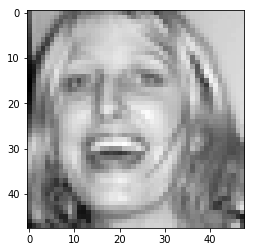

In [7]:
idx = 5
plt.imshow(x_train[idx,:,:], cmap="gray")
y_train[idx,:]

In [8]:
def conv(filters, kernel=5, strides=2, padding="same", lrelu=0.1):
    def run(vol):
        x = Conv2D(filters, kernel, strides=strides, padding=padding)(vol)
        x = BatchNormalization()(x)
        x = LeakyReLU(lrelu)(x)
        return x
    return run

def deconv(filters, kernel=5, strides=2, padding="same", lrelu=0.1):
    def run(vol):
        x = Conv2DTranspose(filters, kernel, strides=strides, padding=padding)(vol)
        x = BatchNormalization()(x)
        x = LeakyReLU(lrelu)(x)
        return x
    return run

def build_ae(input_shape, lrelu_par=0.2):
    
    #encoder
    pic = Input(shape=input_shape)
    
    x = conv(64)(pic)
    x = conv(128)(x)
    x = conv(128)(x)
    x = conv(128, kernel=2)(x)
    
    encoder = Model(inputs=[pic], outputs=[x])
    encoder.summary()
    
    #decoder
    enc = Input(shape=(3,3,128))
    x = deconv(128, kernel=2)(enc)
    x = deconv(128)(x)
    x = deconv(64)(x)
    x = deconv(32)(x)
    x = Conv2D(1, kernel_size=7, strides=1, padding="same", activation="sigmoid")(x)

    decoder = Model(inputs=[enc], outputs=[x])
    
    print(decoder.summary())

    #autoencoder
    autoencoder = Model(inputs=[pic], outputs=decoder(encoder.output))    
    
    return encoder, decoder, autoencoder

In [9]:
encoder, decoder, autoencoder = build_ae([48,48,1],0.1)
autoencoder.compile(loss=losses.binary_crossentropy, optimizer=Adam(0.001, beta_1=0.9, decay=1e-8))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 128)       0         
__________

In [37]:
history = autoencoder.fit(X_train, X_train, validation_data=(X_dev, X_dev), epochs=200, batch_size=128)

Train on 9000 samples, validate on 1000 samples
Epoch 1/200
9000/9000 [==============================] - 8s 929us/step - loss: 0.5656 - val_loss: 0.6478
Epoch 2/200
9000/9000 [==============================] - 7s 781us/step - loss: 0.5205 - val_loss: 0.6446
Epoch 3/200
9000/9000 [==============================] - 7s 781us/step - loss: 0.5124 - val_loss: 0.6162
Epoch 4/200
9000/9000 [==============================] - 7s 781us/step - loss: 0.5098 - val_loss: 0.5814
Epoch 5/200
9000/9000 [==============================] - 7s 781us/step - loss: 0.5080 - val_loss: 0.5516
Epoch 6/200
9000/9000 [==============================] - 7s 782us/step - loss: 0.5062 - val_loss: 0.5294
Epoch 7/200
9000/9000 [==============================] - 7s 780us/step - loss: 0.5039 - val_loss: 0.5165
Epoch 8/200
9000/9000 [==============================] - 7s 781us/step - loss: 0.5030 - val_loss: 0.5017
Epoch 9/200
9000/9000 [==============================] - 7s 783us/step - loss: 0.5020 - val_loss: 0.4989
Epoch 1

Epoch 78/200
9000/9000 [==============================] - 7s 785us/step - loss: 0.4912 - val_loss: 0.4907
Epoch 79/200
9000/9000 [==============================] - 7s 785us/step - loss: 0.4911 - val_loss: 0.4895
Epoch 80/200
9000/9000 [==============================] - 7s 786us/step - loss: 0.4911 - val_loss: 0.4916
Epoch 81/200
9000/9000 [==============================] - 7s 787us/step - loss: 0.4911 - val_loss: 0.4889
Epoch 82/200
9000/9000 [==============================] - 7s 787us/step - loss: 0.4910 - val_loss: 0.4895
Epoch 83/200
9000/9000 [==============================] - 7s 787us/step - loss: 0.4910 - val_loss: 0.4890
Epoch 84/200
9000/9000 [==============================] - 7s 784us/step - loss: 0.4909 - val_loss: 0.4900
Epoch 85/200
9000/9000 [==============================] - 7s 784us/step - loss: 0.4911 - val_loss: 0.4995
Epoch 86/200
9000/9000 [==============================] - 7s 784us/step - loss: 0.4908 - val_loss: 0.4894
Epoch 87/200
9000/9000 [======================

Epoch 155/200
9000/9000 [==============================] - 7s 784us/step - loss: 0.4891 - val_loss: 0.4873
Epoch 156/200
9000/9000 [==============================] - 7s 786us/step - loss: 0.4890 - val_loss: 0.4879
Epoch 157/200
9000/9000 [==============================] - 7s 786us/step - loss: 0.4890 - val_loss: 0.4876
Epoch 158/200
9000/9000 [==============================] - 7s 786us/step - loss: 0.4889 - val_loss: 0.4880
Epoch 159/200
9000/9000 [==============================] - 7s 787us/step - loss: 0.4889 - val_loss: 0.4875
Epoch 160/200
9000/9000 [==============================] - 7s 787us/step - loss: 0.4889 - val_loss: 0.4871
Epoch 161/200
9000/9000 [==============================] - 7s 787us/step - loss: 0.4889 - val_loss: 0.4870
Epoch 162/200
9000/9000 [==============================] - 7s 785us/step - loss: 0.4889 - val_loss: 0.4867
Epoch 163/200
9000/9000 [==============================] - 7s 786us/step - loss: 0.4889 - val_loss: 0.4877
Epoch 164/200
9000/9000 [============

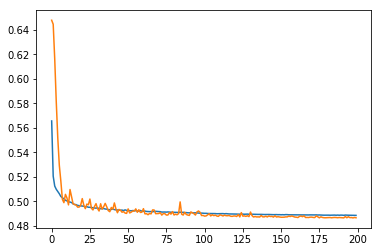

In [38]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [39]:
#autoencoder.save_weights("ae_conv_faces_3_.h5")

In [10]:
autoencoder.load_weights("./ae_conv_faces_3.h5")

In [11]:
E_test = encoder.predict(X_dev)
D_test = decoder.predict(E_test)

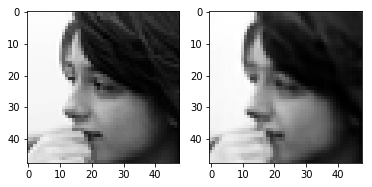

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True, sharex=True)
i=5
ax1.imshow(X_dev[i,:,:,0],cmap="gray")
ax2.imshow(D_test[i,:,:,0],cmap="gray")

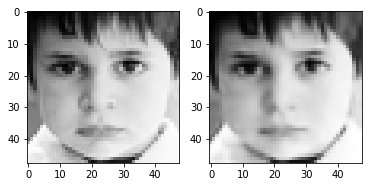

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True, sharex=True)
i=6
ax1.imshow(X_dev[i,:,:,0],cmap="gray")
ax2.imshow(D_test[i,:,:,0],cmap="gray")

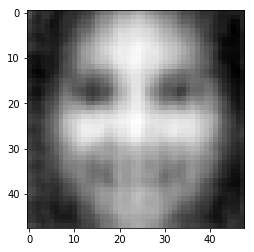

In [14]:
avg_happy_E = np.mean(E_test[(y_dev==1).reshape((-1))], axis=0, keepdims=True)
avg_happy = decoder.predict(avg_happy_E)
plt.imshow(avg_happy[0,:,:,0],cmap="gray")

In [15]:
E_test.shape

(1000, 3, 3, 128)

In [16]:
enc_p = E_test[6,:,:,:]
def plot(x):
    enc = x*avg_happy_E+(1-x)*enc_p
    enc = enc.reshape((1,3,3,-1))
    dec = decoder.predict(enc)
    plt.imshow(dec[0,:,:,0],cmap="gray")
    plt.show()
    
interact(plot,x=(-1,1,0.01))

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

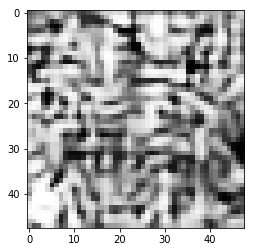

In [15]:
E_rand = np.random.randn(1,3,3,128)
D_rand = decoder.predict(E_rand)
plt.imshow(D_rand[0,:,:,0],cmap="gray")

In [16]:
E_test_r = E_test.reshape((len(E_test),-1))

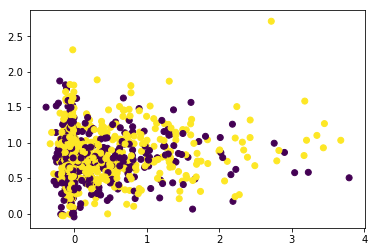

In [17]:
plt.scatter(E_test_r[:,0], E_test_r[:,1], c=y_dev.reshape((-1,)).astype(np.float))